In [2]:
from pandas import Timedelta, to_datetime
from matplotlib.pyplot import subplots, savefig, show, legend, close
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from tqdm import tqdm
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect

subset_data: bool = False


def make_biometrics_plots_together_matplotlib(
    data: defaultdict[str, defaultdict[str, defaultdict[str, Series]]],
    user_id: str,
    session_id: str,
    dataset: str,
    experiment_info: DataFrame,
    **kwargs,
) -> None:
    data = {key: val for key, val in data.items() if val is not None}
    fig, axs = subplots(
        len(data.keys()), 1, figsize=(14, 11 * len(data.keys())), sharex=True
    )
    if len(data.keys()) == 1:
        axs = [axs]
    
    for n, (data_type, physiological_data) in tqdm(
        enumerate(data.items()), desc="Plotting data", total=len(data.keys())
    ):
        if physiological_data is None:
            continue

        for side, specific_side_data in physiological_data.items():
            user_data: DataFrame = specific_side_data[user_id]

            if data_type == "EDA":
                eda_type: str = kwargs["eda_type"]
                data_to_plot = user_data[eda_type]
            else:
                data_to_plot = user_data.iloc[:, 0]

            data_to_plot = data_to_plot.loc[IndexSlice[session_id, :]]
            if subset_data:
                data_to_plot = data_to_plot[:1000]

            data_to_plot.index = to_datetime(data_to_plot.index)
            axs[n].plot(
                data_to_plot.index,
                data_to_plot.values,
                label=side,
                linestyle="-",
            )
            axs[n].set_title(data_type)

            # del data_to_plot
            # garbage_collect()

        # session_id_corrected: Timestamp = to_datetime(
        #     session_ids["left"].split("-")[0], format="%y%m%d"
        # )  + Timedelta("1D")
        # session_id_corrected: str = str(session_id_corrected.date())
        if dataset == "mwc2022":
            start_exp = Timestamp(
                experiment_info.loc[IndexSlice[user_id, session_id], "actual_bed_time"]
            )
            end_exp = Timestamp(
                experiment_info.loc[IndexSlice[user_id, session_id], "wake_up_time"]
            )
            # start_exp = start_exp.tz_localize("Europe/Rome")
            # end_exp = end_exp.tz_localize("Europe/Rome")

            axs[n].axvspan(
                xmin=start_exp,
                xmax=end_exp,
                color="#828282",
                alpha=0.3,
                label="sleep time",
            )
            axs[n].set_ylabel(f"Time")
            axs[n].set_ylabel(f"{data_type}")
        elif dataset == "usi_laughs":
            events = set(
                ["_".join(col.split("_")[1:]) for col in experiment_info.columns]
            )
            for i, event in enumerate(events):
                start_exp = Timestamp(experiment_info.loc[user_id, f"start_{event}"])
                end_exp = Timestamp(experiment_info.loc[user_id, f"end_{event}"])
                if "baseline" in event and i == 0:
                    label = "baseline"
                elif "baseline" not in event:
                    label = event
                else:
                    label = None

                axs[n].axvspan(
                    xmin=start_exp,
                    xmax=end_exp,
                    color="#828282" if "baseline" in event else "#548572",
                    alpha=0.3,
                    label=label,
                )
                axs[n].set_ylabel(f"Time")
                axs[n].set_ylabel(f"{data_type}")
        else:
            raise ValueError(
                f"Received as dataset {dataset}, but only mwc2022 and usi_laughs are supported"
            )

    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        fontsize="x-large",
        title="Side",
        title_fontsize="xx-large",
        #    loc='best'
    )
    # legend()
    fig.suptitle(
        f"Plots for all singals for user {user_id}, session {session_id}",
        fontsize=30,
        y=0.97,
    )
    savefig(f"../visualizations/{dataset}_{user_id}_{session_id}.pdf")
    # show()
    close()

    return start_exp, end_exp


# Intro

This notebook is intended to provide data exploration for all datasets concerning this Lateralization study. As the moment, the datasets impemented are:
* USILaughs
* MWC2022 study

I split the same notebook into 2, since I was having problems w/ remote working, due too large filesizes.

# USILaughs

## Cognitive Load Info

In [3]:
from pandas import read_csv, to_datetime
from pandas import IndexSlice, DataFrame
import pandas as pd

pd.options.display.precision = 5

In [4]:
def move_event_to_columns(df):
    starts = {}
    ends = {}
    for event in df.index.get_level_values(1).unique():
        starts[f"start_{event}"] = df.loc[IndexSlice[:, event], "start"].values
        ends[f"end_{event}"] = df.loc[IndexSlice[:, event], "end"].values
    return DataFrame({**starts, **ends})


experiment_info = read_csv(
    "../data.nosync/usilaughs/all_experimento_info.csv", index_col=[0, 1]
)
indexes_to_drop = [
    idx
    for idx in experiment_info.index
    if "baseline" not in idx[1] and "cognitive_load" not in idx[1]
]
experiment_info = experiment_info.drop(indexes_to_drop, inplace=False)
experiment_info = experiment_info.groupby(axis=0, level=0, group_keys=True).apply(
    move_event_to_columns
)
experiment_info.index = experiment_info.index.droplevel(1)


In [5]:
experiment_info = experiment_info.applymap(to_datetime)
experiment_info = experiment_info.applymap(lambda x: x.tz_localize('Europe/Rome'))

## Physiological Data

In [6]:
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from tqdm import tqdm
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect

eda_data_base_path: str = "../data.nosync/usilaughs/filtered/*/EDA/*.parquet"
acc_data_base_path: str = "../data.nosync/usilaughs/filtered/*/ACC/*.parquet"

eda_data_paths: list[str] = glob(eda_data_base_path)
acc_data_paths: list[str] = glob(acc_data_base_path)
eda_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
    lambda: defaultdict()
)
for file in tqdm(eda_data_paths, desc="Loading EDA data"):
    side_name = file.split("/")[-3]
    user_name = file.split("/")[-1].split(".")[0]
    eda_data[side_name][user_name] = read_parquet(file)
    
   
acc_data = None
# acc_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
#     lambda: defaultdict()
# ) 
# for file in tqdm(acc_data_paths, desc="Loading ACC data"):
#     side_name = file.split("/")[-3]
#     user_name = file.split("/")[-1].split(".")[0]
#     acc_data[side_name][user_name] = read_parquet(file)

bvp_data = None

# bvp_data_base_path: str = "../data/filtered/*/BVP/*.parquet"
# bvp_data_paths: list[str] = glob(bvp_data_base_path)
# bvp_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
#     lambda: defaultdict()
# )
# for file in tqdm(bvp_data_paths, desc="Loading BVP data"):
#     side_name = file.split("/")[-3]
#     user_name = file.split("/")[-1].split(".")[0]
#     bvp_data[side_name][user_name] = read_parquet(file)
    
    
physiological_data: dict[str, defaultdict[str, defaultdict[str, Series]]] = {
    "EDA": eda_data,
    "BVP": bvp_data,
    'ACC': acc_data,
}
del eda_data
del bvp_data
del acc_data
garbage_collect()

Loading EDA data:   0%|          | 0/67 [00:00<?, ?it/s]

57

After inspection, user 40 has to be removed, since his experiment time and the timestamps from the E4 do not match.

In [7]:
experiment_info = experiment_info.drop('s040', axis=0, inplace=False)
del physiological_data['EDA']['left']['s040']
del physiological_data['EDA']['right']['s040']
# del physiological_data['BVP']['left']['s040']
# del physiological_data['BVP']['right']['s040']

In [8]:
users_left = physiological_data["EDA"]["left"].keys()
users_right = physiological_data["EDA"]["right"].keys()
users = list(set(users_left) & set(users_right))
sessions_all = ['experiment']

In [9]:
# session = session_selection.value
for user in tqdm(sorted(users), desc='Plotting user data', colour='red'):
    for session in sessions_all:
        make_biometrics_plots_together_matplotlib(
            data=physiological_data,
            user_id=user,
            session_id=session,
            dataset='usi_laughs',
            experiment_info=experiment_info,
            eda_type="mixed-EDA",
        )


Plotting user data:   0%|          | 0/32 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
users_in_left_side = set(physiological_data['EDA']['left'].keys())
users_in_right_side = set(physiological_data['EDA']['right'].keys())

In [11]:
print(f"Number of users with both left and right hand data: {len(users_in_left_side & users_in_right_side)}")

Number of users with both left and right hand data: 32


## Segmentation

The segmentation will be performed over `baseline_1` and `cognitive_load` periods. Other baselines are not considered, since they were very short periods performed after some activity, one of which was cognitive load itself. As such, brian phenomena from those activites might propagate in the EDA signal and make the classification harded.

In [12]:
experiment_info_as_dict: dict[str, Series] = {
    participant: experiment_info.loc[participant, :]
    for participant in list(experiment_info.index.unique())
}

In [13]:
segment_size_in_secs = 4
eda_sample_rate = 4
segment_size_in_sampling_rate: int = segment_size_in_secs * eda_sample_rate

In [14]:
eda_data = physiological_data['EDA']

In [15]:
from numpy import nan, ndarray
from pandas import Timedelta


def get_session_moment(start: Timestamp, end: Timestamp, info: Series) -> int | float:
    # TODO: check that this is working as expected
    # this method gives 0 if the person is awake and 1 if the person is
    if (end < info["end_baseline_1"]) or (
        (start < info["end_baseline_1"] and end > info["end_baseline_1"])
    ):
        return 0
    elif (start > info["end_baseline_1"] and end < info["start_cognitive_load"]) or (
        start > info["end_cognitive_load"]) or (
            start < info["start_cognitive_load"] and end > info["start_cognitive_load"]
        ):
        return nan
    else:
        return 1


data_segmented_left: list[tuple] = []
data_segmented_right: list[tuple] = []
users = list(set(eda_data["left"].keys()) & set(eda_data["right"].keys()))

for user in tqdm(users, desc='User progress', colour='blue'):
    data_left = eda_data["left"][user]
    data_right = eda_data["right"][user]
    info = experiment_info_as_dict[user]
    
    # FIXME: using sessions like this seems stupid, but allows to reuse code
    # from the other experiment. I should however find a way around it
    sessions_all = ['experiment']
    for session in sessions_all:
        session_data_left: DataFrame = data_left.loc[IndexSlice[session, :], :]
        session_data_right: DataFrame = data_right.loc[IndexSlice[session, :], :]

        session_info = info

        starts_left = session_data_left[
            ::segment_size_in_sampling_rate
        ].index.get_level_values(1)
        starts_right = session_data_right[
            ::segment_size_in_sampling_rate
        ].index.get_level_values(1)

        ends_left = (
            session_data_left[::segment_size_in_sampling_rate].index.get_level_values(1)
            + Timedelta(f"{segment_size_in_secs}s")
            - Timedelta(f"{1/eda_sample_rate}s")
        )
        ends_right = (
            session_data_right[::segment_size_in_sampling_rate].index.get_level_values(
                1
            )
            + Timedelta(f"{segment_size_in_secs}s")
            - Timedelta(f"{1/eda_sample_rate}s")
        )

        segments_left = [
            (
                session_data_left.loc[
                    IndexSlice[session, start:end],
                    "mixed-EDA",
                ].values,
                get_session_moment(start, end, session_info),
                user,
            )
            for start, end in zip(starts_left, ends_left)
        ]
        segments_right = [
            (
                session_data_right.loc[
                    IndexSlice[session, start:end],
                    "mixed-EDA",
                ].values,
                get_session_moment(start, end, session_info),
                user,
            )
            for start, end in zip(starts_right, ends_right)
        ]
        data_segmented_left.append(segments_left)
        data_segmented_right.append(segments_right)


User progress:   0%|          | 0/32 [00:00<?, ?it/s]

In [16]:
from numpy import isnan
values_left = [
    val[0]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]
values_right = [
    val[0]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

labels_left = [
    val[1]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]
labels_right = [
    val[1]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

groups_left = [
    val[2]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]

groups_right = [
    val[2]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

0    480
1    384
dtype: int64
0    55.55556
1    44.44444
dtype: float64


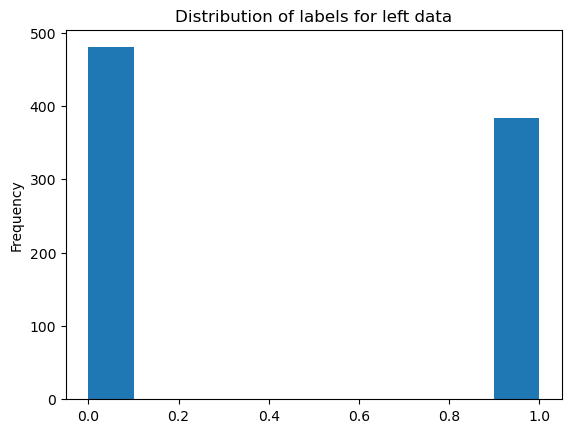

In [17]:
import matplotlib.pyplot as plt

Series(labels_left).plot(kind="hist")
plt.title('Distribution of labels for left data')
print(Series(labels_left).value_counts())
print(Series(labels_left).value_counts()/Series(labels_left).count()*100)

0    480
1    384
dtype: int64
0    55.55556
1    44.44444
dtype: float64


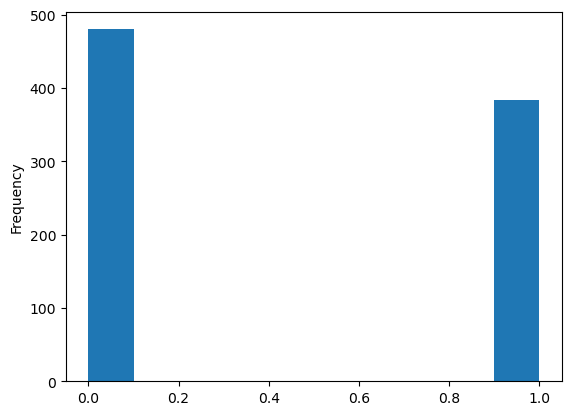

In [18]:
Series(labels_right).plot(kind="hist")
print(Series(labels_right).value_counts())
print(Series(labels_right).value_counts()/Series(labels_right).count()*100)

The distribution is almost balanced: as such, re-balancing should not be a large problem.

## Feature Extraction

In [19]:
from sys import path
path.append("../")
from joblib import Parallel, delayed
from src.feature_extraction.eda import get_eda_features
from numpy import stack

features_left = Parallel(n_jobs=-1)(delayed(get_eda_features)(value) for value in (values_left))
features_right = Parallel(n_jobs=-1)(delayed(get_eda_features)(value) for value in (values_right))

features_left: ndarray = stack(features_left)
features_right: ndarray = stack(features_right)

labels_left: ndarray = stack(labels_left)
labels_right: ndarray = stack(labels_right)

groups_left: ndarray = stack(groups_left)
groups_right: ndarray = stack(groups_right)

/Users/leonardoalchieri/miniconda3/envs/laugh/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/leonardoalchieri/miniconda3/envs/laugh/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/leonardoalchieri/miniconda3/envs/laugh/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/leonardoalchieri/miniconda3/envs/laugh/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/leonardoalchieri/miniconda3/envs/laugh/lib/python3.10/site-packag

In [20]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")

features_left.shape=(864, 11)
labels_left.shape=(864,)
groups_left.shape=(864,)


# Cliff Delta

In [21]:
from effect_size_analysis.cliff_delta import cliff_delta

from pandas import Series
from numpy import isnan, nan, sign

def get_cliff_bin(x: Series, dull: list[str] | None = None, raise_nan: bool = False) -> str:
    x_sign = sign(x)
    x = abs(x)
    if dull is None:
        dull: dict[str, str] = {'small': 0.11, 'medium': 0.28, 'large': 0.43} # effect sizes from (Vargha and Delaney (2000)) "negligible" for the rest=
    if x < dull['small']:
        return 0*x_sign
    elif dull['small'] <= x < dull['medium']:
        return 1*x_sign
    elif dull['medium'] <= x < dull['large']:
        return 2*x_sign
    elif x >= dull['large']:
        return 3*x_sign
    else:
        if isnan(x):
            if raise_nan:
                raise ValueError("NaN value")
            else:
                return nan
        else:
            raise ValueError(f"{x} is not in the dull range")

In [22]:
cognitive_load_data_left = features_left[labels_left == 1]
baseline_data_left = features_left[labels_left == 0]

cognitive_load_data_right = features_right[labels_right == 1]
baseline_data_right = features_right[labels_right == 0]

In [23]:
eda_features = [
    "min_feat",
    "max_feat",
    "mean_feat",
    "std_feat",
    "dynamic_range_feat",
    "slope_feat",
    "absolute_slope_feat",
    "first_derivetive_mean_feat",
    "first_derivative_std_feat",
    "number_of_peaks_feat",
    "peaks_amplitude_feat",
]

In [24]:
alpha = 0.05

cliff_delta_cognitive_load = {}
for i, feature in enumerate(eda_features):
    cliff_delta_cognitive_load[feature] = Series(
        cliff_delta(
            s1=cognitive_load_data_left[:, i],
            s2=cognitive_load_data_right[:, i],
            alpha=alpha,
            accurate_ci=True,
            raise_nan=False,
        ),
        index=['value', 'confidence interval']
        )

cliff_delta_baseline = {}
for i, feature in enumerate(eda_features):
    cliff_delta_baseline[feature] = Series(cliff_delta(
            s1=baseline_data_left[:,i],
            s2=baseline_data_right[:,i],
            alpha=alpha,
            accurate_ci=True,
            raise_nan=False,
        ), index=['value', 'confidence interval'])

In [26]:
cliff_delta_cognitive_load = DataFrame(cliff_delta_cognitive_load)
cliff_delta_baseline = DataFrame(cliff_delta_baseline)
# DataFrame([cliff_delta_cognitive_load, cliff_delta_baseline], index=["cognitive_load", "baseline"])

In [27]:
from pandas import concat

d = {'Cognitive Load' : cliff_delta_cognitive_load, 'Baseline' : cliff_delta_baseline}
cliff_deltas = concat(d.values(), axis=0, keys=d.keys())

In [83]:
cliff_deltas_values = cliff_deltas.loc[IndexSlice[:, 'value'], :]
cliff_deltas_values = cliff_deltas_values.droplevel(level=1, axis=0)
cliff_delta_bins = cliff_deltas_values.applymap(get_cliff_bin)

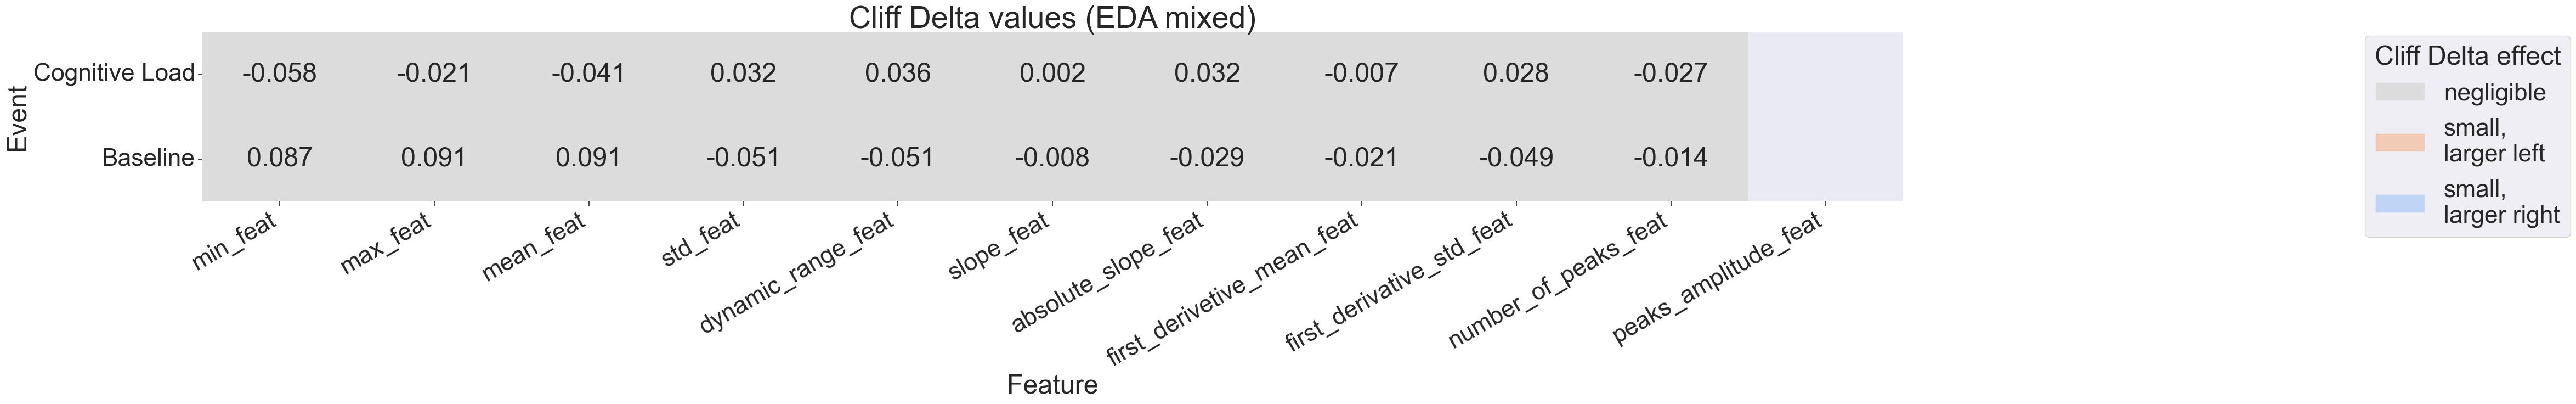

In [84]:
from matplotlib.pyplot import xticks, xlabel, ylabel, legend, cm, figure, title
from matplotlib.patches import Patch
from seaborn import set, heatmap


cmap = cm.coolwarm
figure(figsize=(40, 4))
ax = heatmap(cliff_delta_bins, 
        xticklabels=cliff_deltas_values.columns,
        vmax=3, vmin=-3, center=0,
        annot=cliff_deltas_values.astype(float).round(decimals=3),
        cmap=cmap,
        fmt='',
        cbar=False,
        yticklabels=cliff_deltas_values.index)
ax.tick_params(left=True, bottom=True)
xticks(rotation=30, ha='right')
xlabel('Feature')
ylabel('Event')
title(
    "Cliff Delta values (EDA mixed)", fontsize=40
)
set(font_scale=2.9)

custom_handles = [Patch(facecolor=cmap(0.5), edgecolor=cmap(0.5), label='negligible'),
                Patch(facecolor=cmap(0.6), edgecolor=cmap(0.6), label='small,\nlarger left'),
                Patch(facecolor=cmap(0.4), edgecolor=cmap(0.4), label='small,\nlarger right')]
legend(handles=custom_handles, bbox_to_anchor=(1.4, 1.05), title='Cliff Delta effect')
# savefig("../visualizations/cliff_delta_confrontations_eda.pdf",  bbox_inches='tight')
show()

In [29]:
cliff_deltas_values = cliff_deltas.loc[IndexSlice[:, 'confidence interval'], :].applymap(lambda x: x[-1])
cliff_deltas_values = cliff_deltas_values.droplevel(level=1, axis=0)
cliff_delta_bins = cliff_deltas_values.applymap(get_cliff_bin)

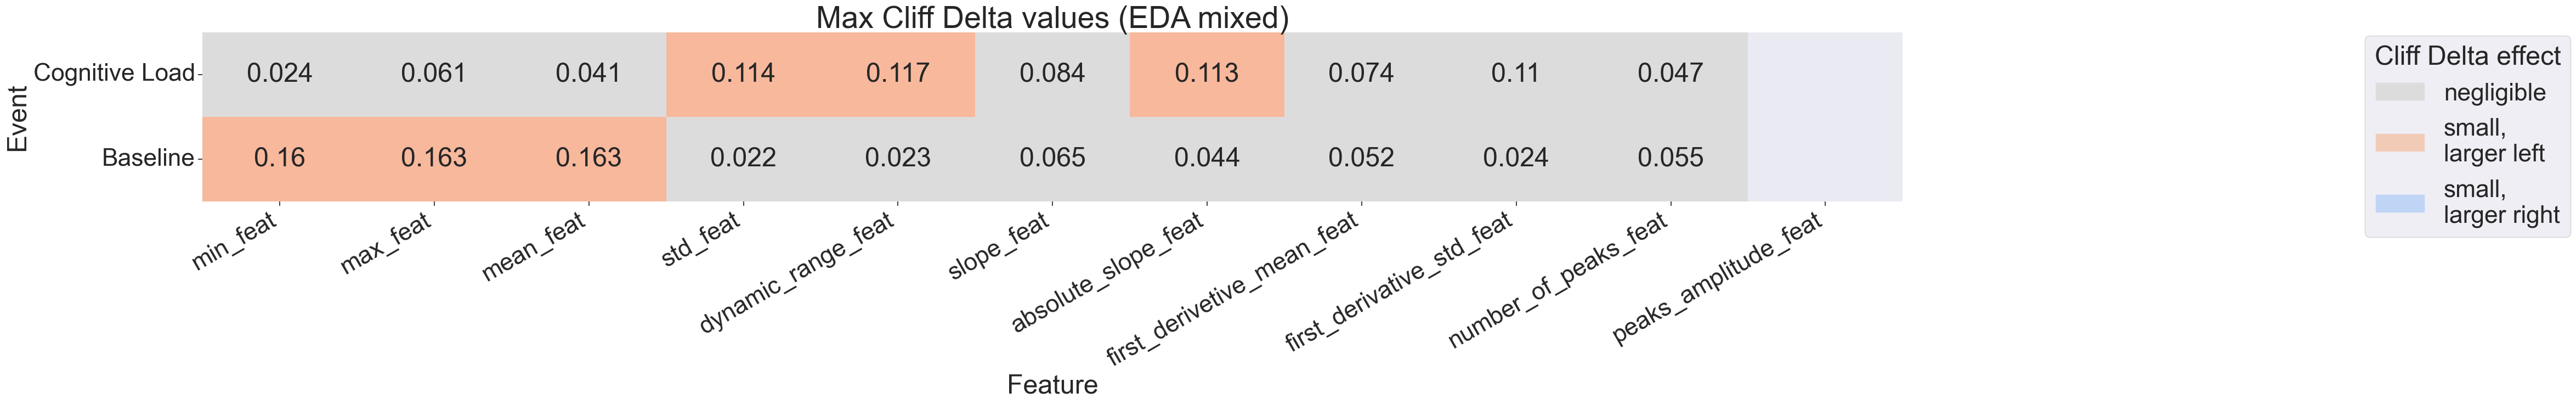

In [32]:
from matplotlib.pyplot import xticks, xlabel, ylabel, legend, cm, figure, title
from matplotlib.patches import Patch
from seaborn import set, heatmap


cmap = cm.coolwarm
figure(figsize=(40, 4))
ax = heatmap(cliff_delta_bins, 
        xticklabels=cliff_deltas_values.columns,
        vmax=3, vmin=-3, center=0,
        annot=cliff_deltas_values.astype(float).round(decimals=3),
        cmap=cmap,
        fmt='',
        cbar=False,
        yticklabels=cliff_deltas_values.index)
ax.tick_params(left=True, bottom=True)
xticks(rotation=30, ha='right')
xlabel('Feature')
ylabel('Event')
title(
    "Max Cliff Delta values (EDA mixed)", fontsize=40
)
set(font_scale=2.9)

custom_handles = [Patch(facecolor=cmap(0.5), edgecolor=cmap(0.5), label='negligible'),
                Patch(facecolor=cmap(0.6), edgecolor=cmap(0.6), label='small,\nlarger left'),
                Patch(facecolor=cmap(0.4), edgecolor=cmap(0.4), label='small,\nlarger right')]
legend(handles=custom_handles, bbox_to_anchor=(1.4, 1.05), title='Cliff Delta effect')
# savefig("../visualizations/cliff_delta_confrontations_eda.pdf",  bbox_inches='tight')
show()

In [33]:
cliff_deltas_values = cliff_deltas.loc[IndexSlice[:, 'confidence interval'], :].applymap(lambda x: x[0])
cliff_deltas_values = cliff_deltas_values.droplevel(level=1, axis=0)
cliff_delta_bins = cliff_deltas_values.applymap(get_cliff_bin)

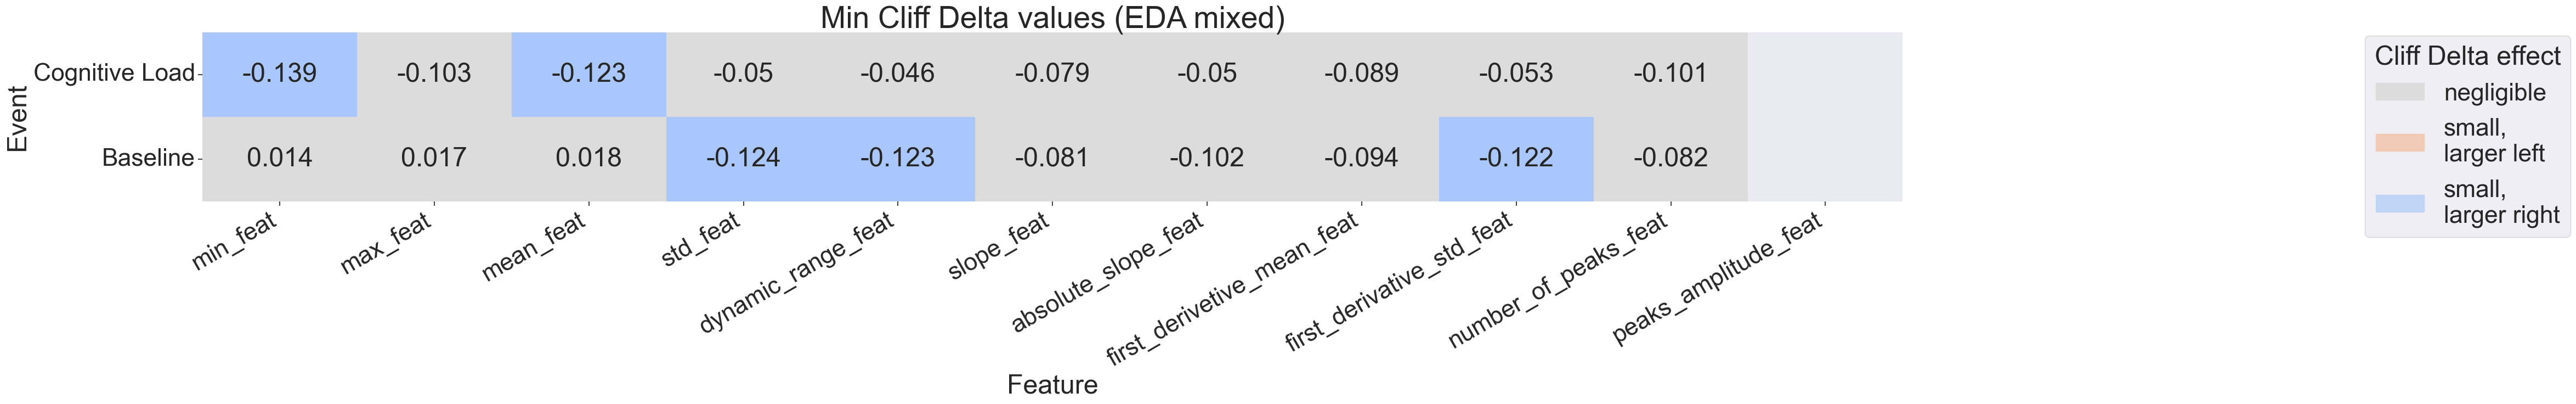

In [34]:
from matplotlib.pyplot import xticks, xlabel, ylabel, legend, cm, figure, title
from matplotlib.patches import Patch
from seaborn import set, heatmap


cmap = cm.coolwarm
figure(figsize=(40, 4))
ax = heatmap(cliff_delta_bins, 
        xticklabels=cliff_deltas_values.columns,
        vmax=3, vmin=-3, center=0,
        annot=cliff_deltas_values.astype(float).round(decimals=3),
        cmap=cmap,
        fmt='',
        cbar=False,
        yticklabels=cliff_deltas_values.index)
ax.tick_params(left=True, bottom=True)
xticks(rotation=30, ha='right')
xlabel('Feature')
ylabel('Event')
title(
    "Min Cliff Delta values (EDA mixed)", fontsize=40
)
set(font_scale=2.9)

custom_handles = [Patch(facecolor=cmap(0.5), edgecolor=cmap(0.5), label='negligible'),
                Patch(facecolor=cmap(0.6), edgecolor=cmap(0.6), label='small,\nlarger left'),
                Patch(facecolor=cmap(0.4), edgecolor=cmap(0.4), label='small,\nlarger right')]
legend(handles=custom_handles, bbox_to_anchor=(1.4, 1.05), title='Cliff Delta effect')
# savefig("../visualizations/cliff_delta_confrontations_eda.pdf",  bbox_inches='tight')
show()